In [2]:
import os, glob, pickle
import pandas as pd
import re
import time
import itpScraper
from bs4 import BeautifulSoup
import numpy as np
import datetime

In [3]:
def extract_filename_time(x):
    pattern = 'UserSessionDicts_Temp_(\d\d-\d\d-\d\d)_(.*?).pickle'
    return pd.to_datetime("_".join(re.findall(pattern, x)[0]), format="%m-%d-%y_%H%M%p")

In [4]:
fresh_scrape = True

In [5]:
prior_scrape_folders = [f for f in glob.glob("Scrape*") if re.match("Scrape(\d+)", f)]
prior_scrape_folders = sorted(prior_scrape_folders, key=lambda f: int(re.findall("Scrape(\d+)", f)[0]))
most_recent_scrape = prior_scrape_folders[-1]
print("Most recent scrape: {}".format(most_recent_scrape))

if fresh_scrape:
    last_user_scraped = None #Fresh Start
    print("Creating Fresh Scrape")
    new_dir_n = int(re.findall("Scrape(\d+)", most_recent_scrape)[0]) + 1
    new_dir = "Scrape{}".format(new_dir_n)
    print("Creating Directory For New Scrape: {}".format(new_dir))
    os.mkdir(new_dir)
    os.chdir(new_dir)
else:
    os.chdir(most_recent_scrape)
    #Navigate to Last Scrape
    temp_dicts = glob.glob("UserSessionDicts_Temp*")
    # pattern = 'UserSessionDicts_Temp_(\d\d-\d\d-\d\d)_(.*?).pickle'
    temp_dicts = sorted(temp_dicts, key=extract_filename_time)
    print("Last 5 files scraped:\n", temp_dicts[-5:])
    
    filename = temp_dicts[-1]
    with open(filename, 'rb') as f:
        user_dicts_prev = pickle.load(f)
    print("Total Users Scraped Thus Far: {}".format(len(user_dicts_prev)))
    last_user_scraped = list(user_dicts_prev.keys())[-1]
    print("Last User Scraped: {}".format(last_user_scraped))

Most recent scrape: Scrape1
Creating Fresh Scrape
Creating Directory For New Scrape: Scrape2


In [6]:
scraper = itpScraper.itpScraper()

In [7]:
scraper.login()
time.sleep(2.5)

user_dict = scraper.parse_all_user_rsvps(last_user_scraped=last_user_scraped)

Hit error: Message: Unable to locate element: //div[@id='tabAttending']

Creating temporary save of user_dicts.
Hit error: Message: Unable to locate element: //div[@id='tabAttending']

Creating temporary save of user_dicts.
Hit error: Message: Unable to locate element: //div[@id='tabAttending']

Creating temporary save of user_dicts.
Hit error: Message: Unable to locate element: //div[@id='tabAttending']

Creating temporary save of user_dicts.
Hit error: Message: Unable to locate element: //div[@id='tabAttending']

Creating temporary save of user_dicts.
Hit error: Message: Unable to locate element: //div[@id='tabAttending']

Creating temporary save of user_dicts.
Hit error: Message: Unable to locate element: //div[@id='tabAttending']

Creating temporary save of user_dicts.
Hit error: Message: Unable to locate element: //div[@id='tabAttending']

Creating temporary save of user_dicts.
Hit error: Message: Unable to locate element: //div[@id='tabAttending']

Creating temporary save of user

## Alternative Tab Form:
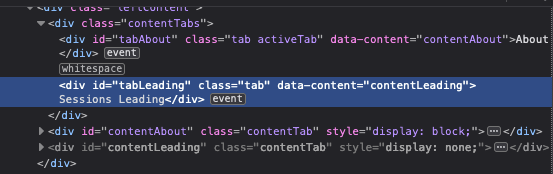

In [8]:
len(user_dict)

218

In [9]:
glob.glob("UserSessionDicts_Complete*")

['UserSessionDicts_Complete_06-16-23_1619PM.pickle']

In [10]:
all_ids = sorted(list(set([s['id'] for sessions in user_dict.values() for s in sessions])))
print(len(all_ids))
all_ids[:5]

264


[1, 8, 9, 10, 11]

In [79]:
sessions_master_dict = {}
user_arrays = {}
user_corpuses = []
errors = []
users_w_errors = []
for ud in [user_dict]:
    user_names = list(ud.keys())
    for user in user_names:
        user_corpus = []
        try:
            user_sessions = ud[user]
            #Create User Array
            u_s_ids = sorted([s['id'] for s in user_sessions])
            user_array = np.isin(all_ids, u_s_ids).astype(int)
            user_arrays[user] = user_array
            for s in user_sessions:
                #Add Tags to User Corpus
                [user_corpus.append(t) for t in s['tags']]
                #If Session Not Previously Seen Cache in Master Session Dict
                if s['id'] not in sessions_master_dict.keys():
                    sessions_master_dict[s['id']] = s
            user_corpus = " ".join(user_corpus)
            user_corpuses.append((user, user_corpus))
        except Exception as e:
            print("Hit Error: ", e)
            errors.append(e)
            users_w_errors.append(user)
print(len(sessions_master_dict.keys()))
#Create DF From Sparse User Arrays
df = pd.DataFrame.from_dict(user_arrays, orient='index')
df.columns = all_ids
print(df.shape)
df.head()

264
(218, 264)


,1,8,9,10,11,12,13,14,15,16,...,314,315,316,317,319,320,321,322,323,324
Abby Schmiedt,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Ada Varriale (she/her),0,0,1,0,1,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
Adeline Setiawan,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
Aki,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Alan Wong,0,1,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [85]:
sorted(Counter(list(user_corpuses[0][1].split())))[:5]

['##physicalcomputing', '##spatialdesign', '#2d', '#3D', '#3d']

In [13]:
time_now = datetime.datetime.now().strftime("%m-%d-%y_%H%M%p")
filename = "UserSessionAttendanceArrays_as_of_{}.csv".format(time_now)
print("Saving to: {}".format(filename))
df.to_csv(filename)

Saving to: UserSessionAttendanceArrays_as_of_06-16-23_1637PM.csv


In [14]:
from sklearn.metrics.pairwise import euclidean_distances
dist = euclidean_distances(df, df)
dist.shape

(218, 218)

In [21]:
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn import metrics
from sklearn.cluster import KMeans

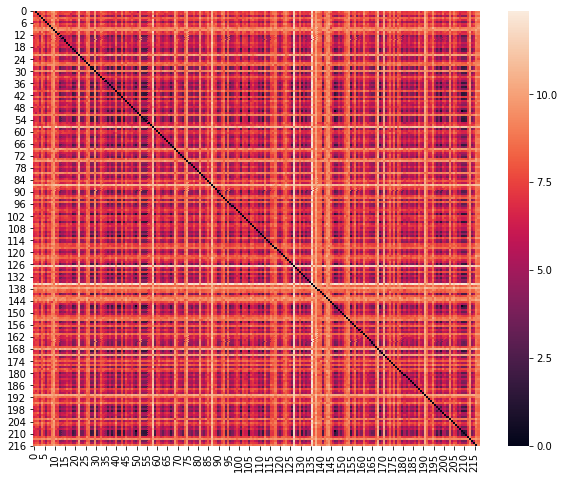

In [22]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(dist)

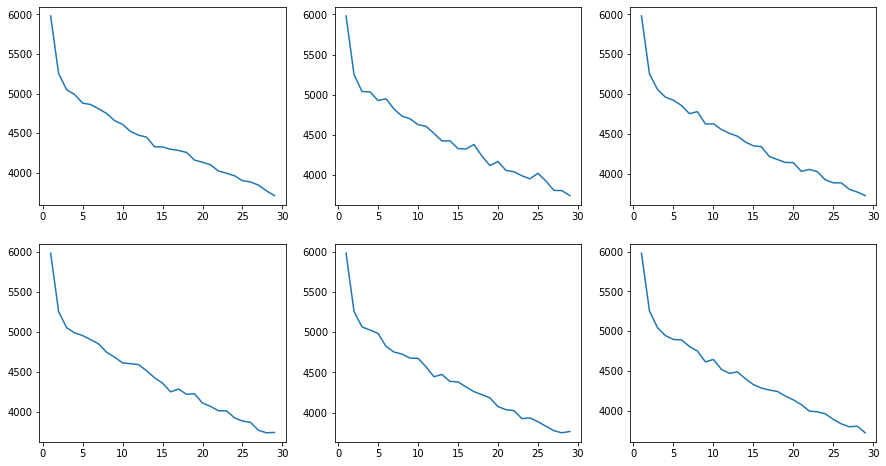

In [23]:
#This has a random seed - you can rerun with slightly different results

ncols = 2
fig, axs = plt.subplots(ncols,3, figsize=(15,8))

for n in range(6):
    cluster_inertias = []
    cluster_sizes = []


    ax = axs[n%ncols][n//ncols]
    for i in range(1,30):
        kmeans = KMeans(
            n_clusters=i,
            max_iter=100,
            n_init=1,
        ).fit(df)

        cluster_inertias.append(kmeans.inertia_)
        cluster_sizes.append(i)
    ax.plot(cluster_sizes, cluster_inertias)

In [24]:
from collections import Counter

In [25]:
kmeans = KMeans(n_clusters=15,
                max_iter=100,
                n_init=1,
                )
clusters = kmeans.fit_predict(df)
print(clusters.shape)
print(Counter(clusters))

(218,)
Counter({3: 91, 13: 34, 7: 24, 0: 16, 14: 15, 1: 12, 4: 8, 12: 5, 8: 3, 9: 2, 5: 2, 6: 2, 10: 2, 2: 1, 11: 1})


In [26]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## PCA Viz

Explained variance:  [0.17287093 0.03697363 0.03155497]


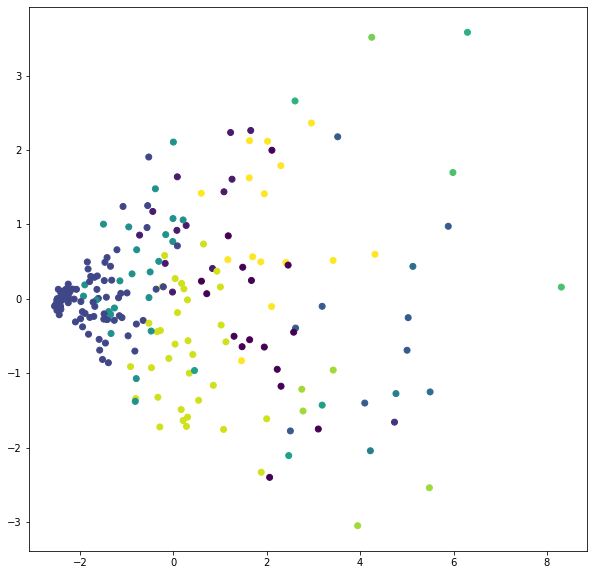

In [27]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df)

print("Explained variance: ",pca.explained_variance_ratio_)
fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(pca_result[:,0], pca_result[:,1], c=clusters)

In [28]:
from mpl_toolkits.mplot3d import Axes3D

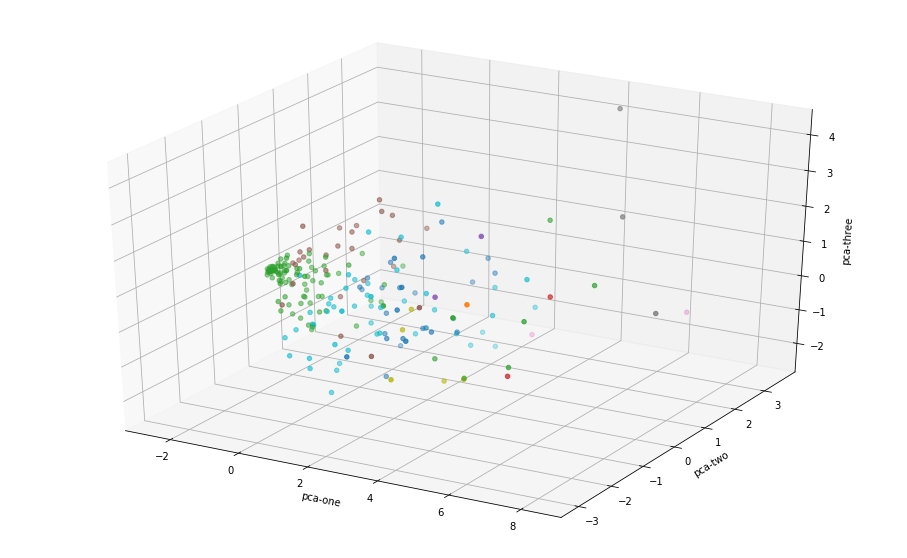

In [29]:
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df["pca-one"], 
    ys=df["pca-two"], 
    zs=df["pca-three"], 
    c=clusters, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

### TSNE

In [30]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 218 samples in 0.000s...
[t-SNE] Computed neighbors for 218 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 218 / 218
[t-SNE] Mean sigma: 1.664517
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.938370
[t-SNE] KL divergence after 300 iterations: 1.093613
t-SNE done! Time elapsed: 0.5297970771789551 seconds


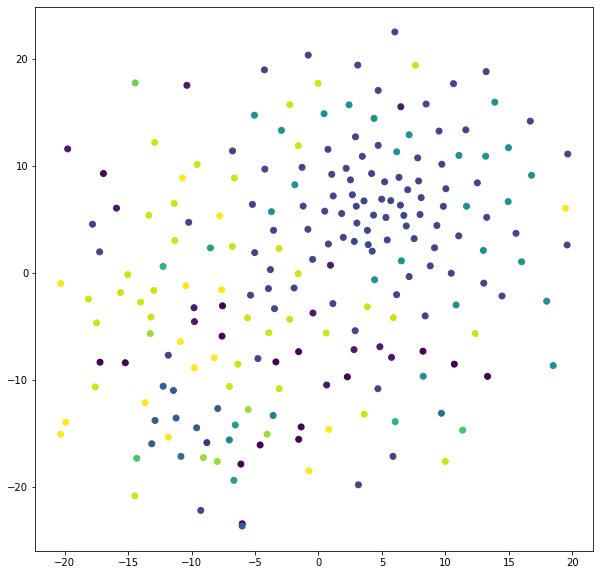

In [31]:
fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=clusters)

In [33]:
time_now

'06-16-23_1637PM'

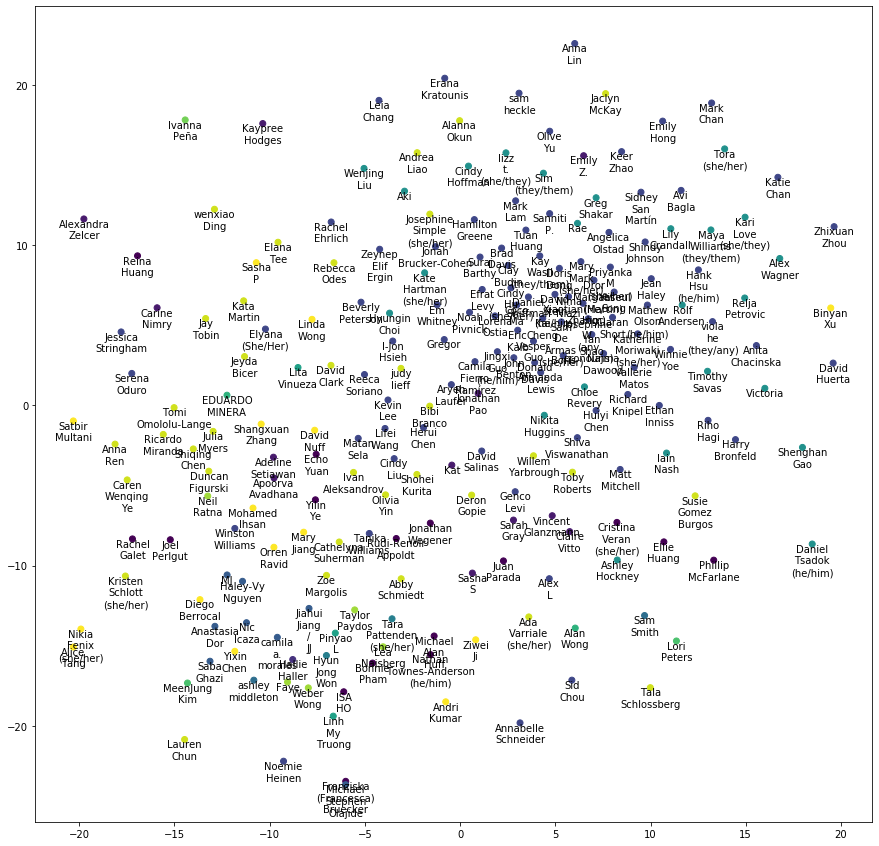

In [34]:
fig, ax = plt.subplots(figsize=(15,15))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=clusters)

# add labels to all points
for (xi, yi, name) in zip(tsne_results[:,0], tsne_results[:,1], df.index):
    plt.text(xi, yi, "\n".join(name.split()), va='top', ha='center')

filename = "ITP_TSNE_Campers_Clustering_{}.png".format(time_now)    
plt.savefig(filename)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 218 samples in 0.001s...
[t-SNE] Computed neighbors for 218 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 218 / 218
[t-SNE] Mean sigma: 1.664517
[t-SNE] KL divergence after 250 iterations with early exaggeration: 156.230316
[t-SNE] KL divergence after 300 iterations: 4.099910


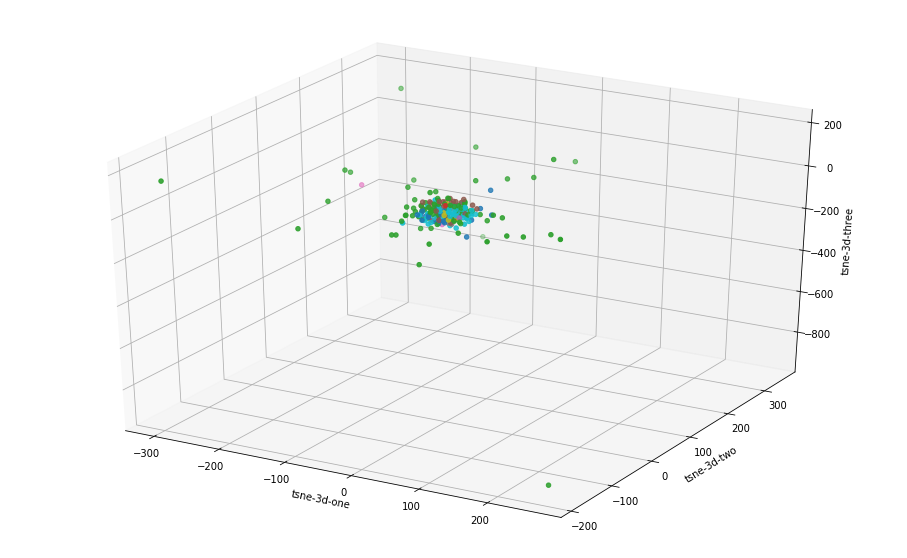

In [35]:
time_start = time.time()
tsne3d = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results_3d = tsne3d.fit_transform(df)

df['tsne-3d-one'] = tsne_results_3d[:,0]
df['tsne-3d-two'] = tsne_results_3d[:,1] 
df['tsne-3d-three'] = tsne_results_3d[:,2]

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df['tsne-3d-one'], 
    ys=df['tsne-3d-two'], 
    zs=df['tsne-3d-three'], 
    c=clusters, 
    cmap='tab10'
)
ax.set_xlabel('tsne-3d-one')
ax.set_ylabel('tsne-3d-two')
ax.set_zlabel('tsne-3d-three')

filename = "ITP_TSNE_Campers_Clustering_3D_{}.png".format(time_now)    
plt.savefig(filename)
plt.show()

## User's 5 Closest Euclidean Pairs:

In [94]:
df.reset_index().head()

,index,1,8,9,10,11,12,13,14,15,...,288,290,291,293,pca-one,pca-two,pca-three,tsne-3d-one,tsne-3d-two,tsne-3d-three
0,Abby Schmiedt,1,0,0,0,1,0,0,1,0,...,0,0,0,0,1.164394,-1.631332,-0.472374,-16.924307,37.095898,-0.441268
1,Ada Varriale (she/her),0,0,1,0,1,0,0,1,0,...,0,0,0,0,0.114797,0.508827,-0.341567,-35.378662,1.147689,15.965610
2,Adeline Setiawan,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0.051105,0.779783,-1.957770,-12.521429,-2.318404,-14.256520
3,Aki,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-1.249912,0.427728,0.538733,12.888682,25.711899,-24.192410
4,Alan Wong,0,0,0,1,1,0,0,1,0,...,0,0,0,0,-0.512527,-0.122902,-1.706515,-22.745930,-6.483883,-4.374103


In [39]:
ex_user = "Matt Mitchell"
temp = df.reset_index().rename(columns={'index':'Name'})
row_number = temp[temp.Name==ex_user].index
print(row_number)

Int64Index([134], dtype='int64')


In [40]:
closest_usr_indices = np.argsort(dist[row_number])[0,:10]
closest_usr_indices
closest_users = temp.loc[closest_usr_indices]['Name']
closest_users

134                           Matt Mitchell
42                                  Coco Ma
155       Priyanka M\n            (she/her)
112      Kay Wasil\n            (they/them)
59                               Efrat Levy
44                          Daniel Shiffman
67                                Eric Kalb
209                  Xiaotian(Martin) Zhang
83                              I-Jon Hsieh
55     Dror Margalit\n            (He/ Him)
Name: Name, dtype: object

In [41]:
from sklearn.metrics import jaccard_score

In [42]:
cols = [col for col in df.columns if type(col)==int]
for user in closest_users:
    score = jaccard_score(df.loc[ex_user][cols], df.loc[user][cols])
    print("{} Jaccard Similarity: {}".format(user, score))

Matt Mitchell Jaccard Similarity: 1.0
Coco Ma Jaccard Similarity: 0.05263157894736842
Priyanka M
            (she/her) Jaccard Similarity: 0.05
Kay Wasil
            (they/them) Jaccard Similarity: 0.05
Efrat Levy Jaccard Similarity: 0.09523809523809523
Daniel Shiffman Jaccard Similarity: 0.05
Eric Kalb Jaccard Similarity: 0.05
Xiaotian(Martin) Zhang Jaccard Similarity: 0.0
I-Jon Hsieh Jaccard Similarity: 0.2
Dror Margalit
            (He/ Him) Jaccard Similarity: 0.0


In [43]:
usr1_s_ids = [col for col in df.columns if df.loc[ex_user][col] == 1]
usr2_s_ids = [col for col in df.columns if df.loc[user][col] == 1]
print(usr1_s_ids)
print(usr2_s_ids)

[10, 12, 34, 49, 50, 64, 72, 79, 81, 89, 104, 114, 130, 190, 224, 252, 256, 257, 311]
[177]


In [44]:
similarities = []
for user in df.index:
    score = jaccard_score(df.loc[ex_user][cols], df.loc[user][cols])
    similarities.append((user, score))
similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
similarities[:10]

[('Matt Mitchell', 1.0),
 ('Kata Martin', 0.24324324324324326),
 ('Winston Williams', 0.22857142857142856),
 ('I-Jon Hsieh', 0.2),
 ('Shohei Kurita', 0.19047619047619047),
 ('Nathan Townes-Anderson (he/him)', 0.1875),
 ('Sasha S', 0.18421052631578946),
 ('David Nuff', 0.18),
 ('Ricardo Miranda', 0.17777777777777778),
 ('Nikia Fenix (she/her)', 0.1746031746031746)]

In [142]:
ex_user = np.random.choice(df.index, 1)[0]
print("Example User: ", ex_user)

similarities = []
for user in df.index:
    score = jaccard_score(df.loc[ex_user][cols], df.loc[user][cols])
    similarities.append((user, score))
similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
similarities[:10]

Example User:  Lori Peters


[('Lori Peters', 1.0),
 ('MeenJung kim', 0.49444444444444446),
 ('Saba Ghazi', 0.45),
 ('Carine Nimry', 0.40625),
 ('EDUARDO MINERA', 0.4025157232704403),
 ('Michael Stephen Olajide', 0.375),
 ('Nic Icaza', 0.35443037974683544),
 ('ashley middleton', 0.35403726708074534),
 ('Neil Ratna', 0.3466666666666667),
 ('Anastasia Dor', 0.34459459459459457)]

In [144]:
user = similarities[1][0]

usr1_s_ids = [col for col in df.columns if df.loc[ex_user][col] == 1]
usr2_s_ids = [col for col in df.columns if df.loc[user][col] == 1]
print("{} {} sessions:\n{}".format(ex_user, len(usr1_s_ids), usr1_s_ids))
print("{} {} sessions:\n{}".format(user, len(usr2_s_ids), usr2_s_ids))

Lori Peters 120 sessions:
[1, 8, 9, 12, 13, 19, 20, 21, 22, 24, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 45, 47, 48, 49, 50, 55, 56, 57, 58, 60, 61, 65, 67, 68, 70, 71, 72, 74, 75, 81, 82, 83, 84, 85, 86, 88, 89, 92, 94, 95, 97, 99, 100, 105, 106, 107, 109, 112, 116, 125, 126, 128, 129, 130, 137, 138, 139, 140, 141, 143, 145, 146, 147, 150, 151, 152, 153, 155, 157, 158, 159, 160, 165, 166, 169, 173, 174, 175, 176, 178, 179, 203, 227, 233, 243, 246, 247, 248, 249, 250, 253, 256, 257, 259, 261, 262, 263, 264, 265, 266, 270, 271, 272, 275, 276, 281]
MeenJung kim 149 sessions:
[1, 8, 14, 16, 17, 18, 19, 21, 22, 24, 25, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 96, 97, 98, 99, 100, 101, 103, 104, 105, 106, 107, 108, 113, 114, 115, 126, 127, 128, 129, 130, 133, 134, 135, 136, 137, 138, 139, 140

Sessions Per Persion Stats
Mean: 34.33 Median: 27.0


Text(0.5, 0, 'Number of Sessions Someone Signed Up For')

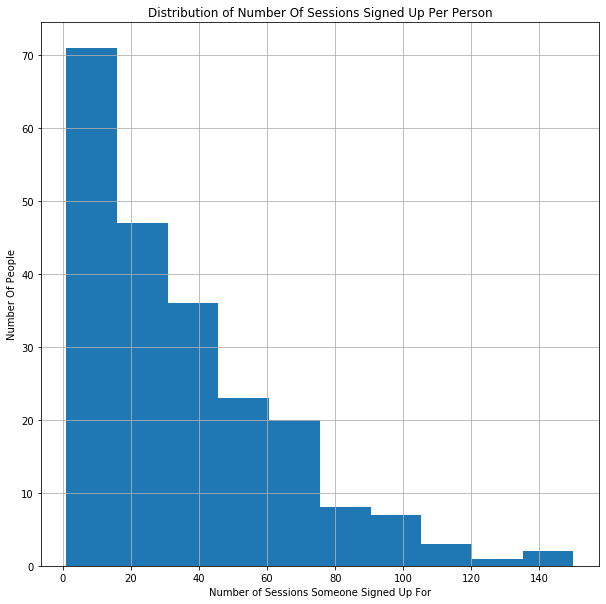

In [45]:
signups_pp = df[cols].sum(axis=1)
print("Sessions Per Persion Stats\nMean: {} Median: {}".format(round(np.mean(signups_pp),2),
                                                              round(np.median(signups_pp),2)
                                                              )
     )
signups_pp.hist(figsize=(10,10))
plt.title("Distribution of Number Of Sessions Signed Up Per Person")
plt.ylabel("Number Of People")
plt.xlabel("Number of Sessions Someone Signed Up For")

## Clustering With Keyword Tags

In [52]:
len(sessions_master_dict)

264

In [56]:
session_id = np.random.choice(list(sessions_master_dict.keys()))
print(session_id)
session_details = sessions_master_dict[session_id]
print(session_details['title'],"\n",session_details['tags'])

1
Reactive Programming with RxJS 
 ['#web', '#javascript', '#code', '#asynchronous']


In [69]:
pwd

'/Users/matthewmitchell/Documents/ITP_Camp/PeopleCluster/Scrape2'

In [71]:
print(type(user_corpuses))
print(len(user_corpuses))

<class 'dict'>
218


In [87]:
ucorp_df = pd.DataFrame(user_corpuses)
ucorp_df.columns = ['Name', 'Tags']
print(ucorp_df.shape)
ucorp_df.head()

(218, 2)


,Name,Tags
0,Abby Schmiedt,#drawing #illustration #code #graphics #3D #vi...
1,Ada Varriale (she/her),#shop #safety training #mandatory #p5.js #crea...
2,Adeline Setiawan,#innovation #materials #fieldtrip #p5.js #crea...
3,Aki,#ai #vr #dall-e 2 #3d #hdri #equirectangular #...
4,Alan Wong,#shop #safety training #mandatory #collage #pa...


In [88]:
corpus = ucorp_df.Tags

In [91]:
import lda
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [92]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=10000,
                                stop_words='english');
tf = tf_vectorizer.fit_transform(corpus)

In [93]:
n_topics = 15
model = lda.LDA(n_topics=n_topics, n_iter=1500, random_state=1);
model.fit(tf);

topic_word = model.topic_word_  # model.components_ also works
vocab = tf_vectorizer.get_feature_names();

INFO:lda:n_documents: 218
INFO:lda:vocab_size: 510
INFO:lda:n_words: 35067
INFO:lda:n_topics: 15
INFO:lda:n_iter: 1500
INFO:lda:<0> log likelihood: -324075
INFO:lda:<10> log likelihood: -245673
INFO:lda:<20> log likelihood: -230557
INFO:lda:<30> log likelihood: -225855
INFO:lda:<40> log likelihood: -222683
INFO:lda:<50> log likelihood: -220209
INFO:lda:<60> log likelihood: -219163
INFO:lda:<70> log likelihood: -218766
INFO:lda:<80> log likelihood: -217853
INFO:lda:<90> log likelihood: -217554
INFO:lda:<100> log likelihood: -217049
INFO:lda:<110> log likelihood: -216595
INFO:lda:<120> log likelihood: -216324
INFO:lda:<130> log likelihood: -215916
INFO:lda:<140> log likelihood: -215819
INFO:lda:<150> log likelihood: -215985
INFO:lda:<160> log likelihood: -215398
INFO:lda:<170> log likelihood: -215291
INFO:lda:<180> log likelihood: -215543
INFO:lda:<190> log likelihood: -215130
INFO:lda:<200> log likelihood: -215005
INFO:lda:<210> log likelihood: -214912
INFO:lda:<220> log likelihood: -21

In [94]:
topic_word = model.topic_word_  # model.components_ also works
vocab = tf_vectorizer.get_feature_names();

n_top_words = 10
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: textiles knitting interactive fiberarts crochet experience phyiscal illustrator sewing
Topic 1: design arduino 3d midi physicalcomputing fabrication wearables led electronics
Topic 2: art games writing fiction interactive creative storytelling ai roleplaying
Topic 3: crafts paper diy communitytech design networking vacuform consumer sculpture
Topic 4: artistic art creativity voice clarity focus insight living truth
Topic 5: art sustainability bioart bioplastics sustainableart workshop scent perfumery food
Topic 6: js coding p5 creative code intro training shop safety
Topic 7: unreal liveperformance motioncapture unrealengine blueprint vjing engine madmapper projectionmapping
Topic 8: music sound audio social digital art generative food allcamp
Topic 9: illustration drawing design shop narrative mandatory safety training tech
Topic 10: javascript js web code html webgl creative p5 ai
Topic 11: design intro interface workflow process habits 101 basics user
Topic 12: 3d art blend

In [95]:
from wordcloud import WordCloud
import math

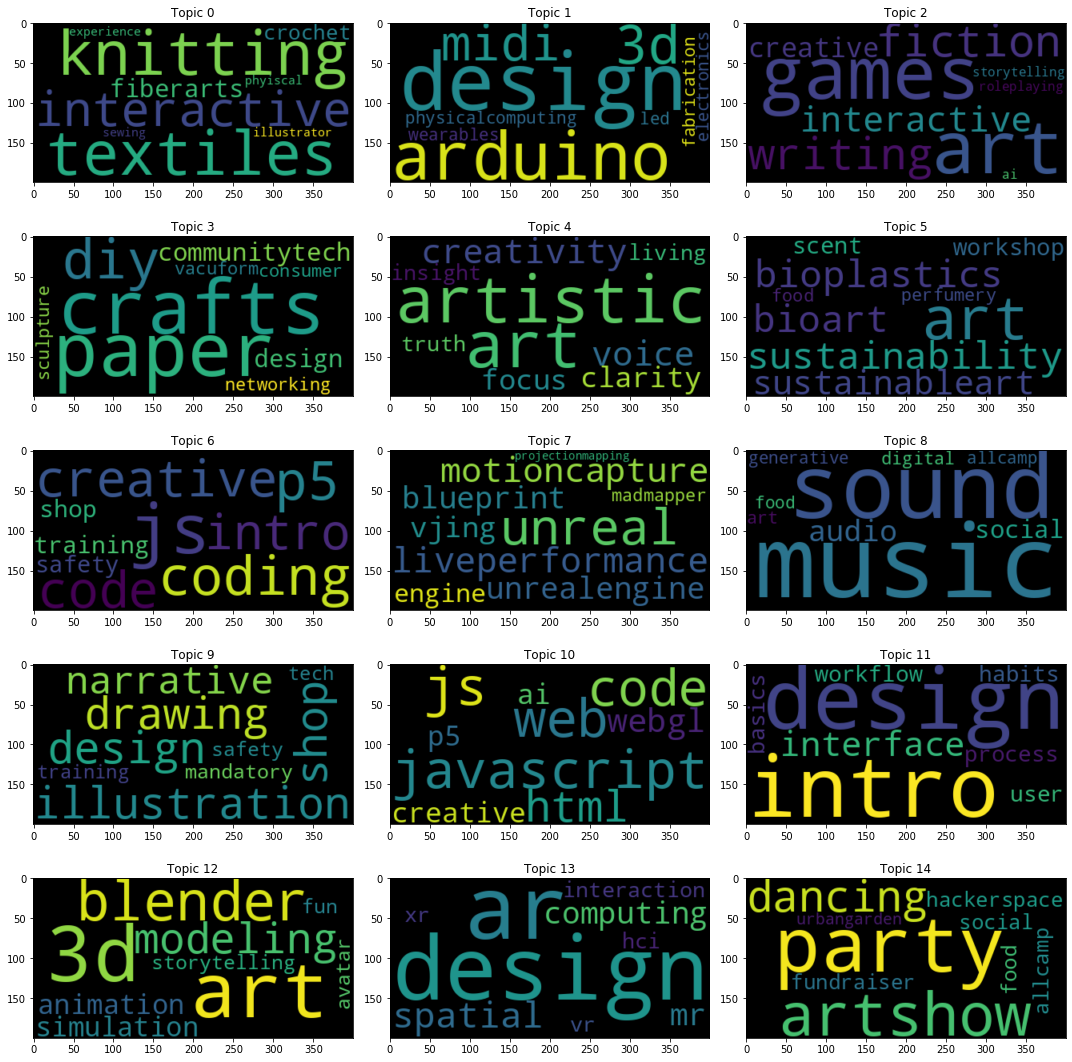

In [96]:
ncols = 3
nrows = math.ceil(n_topics / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(15,15)) #15 topics broken out 3 by 5
fig.tight_layout()
for i, topic_dist in enumerate(topic_word):
    topic_words = list(np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words):-1])
    topic_words = ' '.join(topic_words)
    row = i//ncols
    col = i%ncols
    ax = axes[row, col]
    wordcloud = WordCloud().generate(topic_words)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title('Topic {}'.format(i))
plt.tight_layout()

In [99]:
type(tf)
tf.shape

(218, 510)

In [100]:
len(ucorp_df)

218

In [109]:
cluster_probs = model.transform(tf)
clusters = [np.argmax(i) for i in clusters]
ucorp_df['LDA Tag Cluster'] = clusters
print(ucorp_df['LDA Tag Cluster'].value_counts())
ucorp_df.head()

10    49
12    45
2     20
8     19
1     18
13    11
6     10
11     9
3      9
0      9
7      8
5      5
14     4
9      2
Name: LDA Tag Cluster, dtype: int64


,Name,Tags,LDA Tag Cluster
0,Abby Schmiedt,#drawing #illustration #code #graphics #3D #vi...,10
1,Ada Varriale (she/her),#shop #safety training #mandatory #p5.js #crea...,10
2,Adeline Setiawan,#innovation #materials #fieldtrip #p5.js #crea...,10
3,Aki,#ai #vr #dall-e 2 #3d #hdri #equirectangular #...,2
4,Alan Wong,#shop #safety training #mandatory #collage #pa...,12


In [110]:
time_now = datetime.datetime.now().strftime("%m-%d-%y_%H%M%p")
filename = "LDA_Tag_Clusters_{}.csv".format(time_now)
ucorp_df.to_csv(filename, index=False)

In [111]:
ls *.png

ITP_TSNE_Campers_Clustering_06-16-23_1637PM.png
ITP_TSNE_Campers_Clustering_3D_06-16-23_1637PM.png


In [114]:
ls ../*.png

../CampersCluster.png
../User_Cluster_Interests_Wordcloud.png


![ITP Camp Clusters](CampersCluster.png)